# Description
- Add station to plots (done)
- Overlay importance area and predictor map (done)
- Fix Colorbar to certain values in order to compare figures. Make the upper limit to storm extremes etc.
    - sp: unit (Pa), reasonable vmax = , vmin = 
    - tp: unit (m), reasonable vmax = , vmin = 
    - u10: unit (m/s), reasonable vmax = , vmin = 
    - v10: unit (m/s), reasonable vmax = , vmin = 
    - I chose 95% of max min values but I dont think this is the best choice to see extremes. Go abit lower
- Preprocess: Turn PA into hPa
- Sort into modules

# Working Area

In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

from models import modelfit
from models import evaluation
from models import loader

In [2]:
#--- 
# Initialize
#---
model_run = "rf012"
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
season = "winter" # ["winter", "autumn",] 
percentile = 0.95 # [0.95, 0.99,] 
station_names = ["hanko-han-fin-cmems",] # "wladyslawowo-wla-pol-cmems",]

In [3]:
# Longitudes and Latitudes of all stations
def station_position(gesla_predictand, station_names):
    # TODO: Put into module
    """
    Description:
        Returns positions longitudes and latitudes of GESLA Stations
    Parameters:
        gesla_predictand (xr.Dataset): GESLA Dataset loaded with data_loader.load_gesla(station_names)
        station_names (list): List of station names within GESLA dataset
    Returns:
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
    """
    lon = gesla_predictand.longitude.values
    lat = gesla_predictand.latitude.values

    station_positions = {}
    for station_idx, station_name in enumerate(station_names):
        station_positions[station_name] = [lon[station_idx], lat[station_idx]]

    return station_positions

In [4]:
#---
# Preprocess GESLA Data
# without Detrending.
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Get lon/lat positions of stations
#---
station_positions = station_position(gesla_predictand, station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
gesla_predictand = gesla_predictand["sea_level"] # Select values

# Detrend
# ---
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
#---
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
#---
gesla_predictand = gesla_predictand.to_xarray()
gesla_predictand

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


<xarray.DataArray 'sea_level' (station: 1, date_time: 106357)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * station    (station) int64 0
  * date_time  (date_time) datetime64[ns] 1971-01-01 ... 2020-12-17T07:00:00

In [5]:
station_positions

{'hanko-han-fin-cmems': [22.976601, 59.822899]}

In [6]:
#--
# Add station to plot
# TODO: Add to a module
#---
def plot_station(ax, station_positions, station_name, is_station_name=False, markersize=6, fontsize=12, color="r",):
    """
    Description:
        Plots the position of a station into given axis
    Parameters:
        ax (GeoAxesSubplot): Axis to plot station into
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
        station_name (str): Name of the station given in GESLA dataset.
        is_station_name (bool): Whether to indicate station name in plot or not (Defaults: False)
        
        kwargs**
        markersize (float): Size of the cross used to indicate position of station (Defaults: 10)
        fontsize (float): Fontsize of the name of station (Defaults: 12)
        color (str): Color code (Defaults: "r")
    Returns:
        None
    """
    import matplotlib.pyplot as plt 
    import cartopy.crs as ccrs

    lons = station_positions[station_name][0]
    lats = station_positions[station_name][1]

    # Mark position of station
    ax.plot(lons, lats, 'x', markersize=markersize, color=color, transform=ccrs.PlateCarree())
    
    if is_station_name:
        ax.text(1.001*lons, 1.001*lats, station_name, fontsize=fontsize, transform=ccrs.PlateCarree())

C:\Users\Kai\AppData\Local\Temp\ipykernel_14096\948913816.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot([lons, 0.5*lons], [lats, 1.0*lats], 'bo', markersize=5, alpha=0.1, color="b", transform=ccrs.PlateCarree())


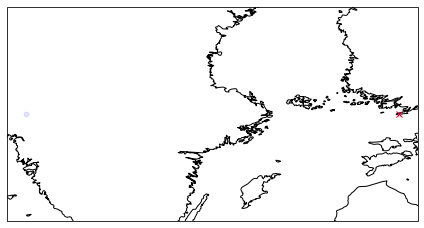

In [7]:
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
fig = plt.figure(tight_layout=True,)
ax = plt.axes(projection=ccrs.PlateCarree())

lons = station_positions[station_names[0]][0]
lats = station_positions[station_names[0]][1]

# mark a known place to help us geo-locate ourselves
for station_name in station_names:
    plot_station(ax, station_positions, station_name,)

ax.plot([lons, 0.5*lons], [lats, 1.0*lats], 'bo', markersize=5, alpha=0.1, color="b", transform=ccrs.PlateCarree())
ax.coastlines()

In [8]:
#---
# Define predictors of each model that is to test.
#---

predictors_of_model = [
    ["tp", "u10"], # rf004_run_id3
    # ["sp",], # rf005_run_id2
]

timelags_of_model = [
    [0,], # rf004_run_id3
    # [3,], # rf005_run_id2
]

models_path = [
    "models/random_forest/rf004/rf004RandomSearchCV_3.sav", # rf004_run_id3
    # "models/random_forest/rf005/rf005RandomSearchCV_2.sav", # rf005_run_id2
]

In [9]:
# Initialize
#---
is_scaled = False
is_optimized = False
is_loaded_hparams = True 
optimizer = "RandomSearchCV"
clf = RandomForestClassifier
k = 3
n_iter = 100

lats, lons = preprocessing.get_lonlats(
    range_of_years,
    subregion,
    season,
    predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
    era5_import=preprocess,
)

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter


In [10]:
# Build Hyperparameter Grid to optimize from.
# For this run, use exactly the same as in rf004 to see if 
# scaling of predictor data leads to any changes.
#---
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
hparam_grid = {'n_estimators': n_estimators, # hparam grid if optimization is needed
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'criterion' : ['gini',],
            'random_state' : [0,], # To compare results when changing hyperparameters
            'class_weight' : ["balanced",],
            'oob_score' : [True,],
            }

In [37]:
def map(data, lons, lats, tflag="", vmin=None, vmax=None, unit=None, is_clb_label=True, nlevels=6):
    # TODO: I Did not change anything here, right? CHeck again and put into module
    """
    Description:
        Plots predictor-data on a lat-lon map.
    Parameters:
        data (np.array): dataset from predictors. Shape:(lat, lon).flatten()
        lons (np.array): Longitudes of predictor data
        lats (np.array): Latitudes of predictor data
        tflag (str): Additional Title information, (Defaults: "")
        vmin (float): Minimum value for colorbar, (Defaults: None)
        vmax (float): Maximum value for colorbar, (Defaults: None)
        unit (str): Unit of data
        is_clb_label (bool): Whether to label the colorbar with unit or not.
        nlevels (int): Number of levels in contour plot (e.g. sections of the colorbar)
    Returns:
        fig: Figure of data
    """
    # Modules
    import matplotlib.pyplot as plt 
    import cartopy.crs as ccrs
    import numpy as np

    # Reshape data to lat/lon
    nlat = len(lats)
    nlon = len(lons)
    data = data.reshape(nlat, nlon)

    # Plot data on lat/lon map
    fig = plt.figure(tight_layout=True,)
    ax = plt.axes(projection=ccrs.PlateCarree())

    plot = ax.contourf(lons, lats, data,
    levels=np.arange(vmin, vmax, (vmax-vmin) / nlevels),
    transform=ccrs.PlateCarree(),
    extend='both',
    )

    ax.coastlines()

    if vmin == None or vmax == None:
        cbarticks = None
    else:
        cbarticks = np.arange(vmin, vmax, (vmax-vmin) / 5) # 5 ticks
        cbarticks = list(cbarticks)
        cbarticks.append(vmax)
        cbarticks = np.array(cbarticks)

    # clb = plt.colorbar(plot, shrink=.62, ticks=cbarticks,)
    clb = plt.colorbar(plot, ticks=cbarticks)

    if is_clb_label:
        clb.set_label(f"{unit}", rotation=90, labelpad=1)

    ax.set_title(f"{tflag}")

    return fig, ax

In [38]:
# Get colorbar vmin vmax
#---
colorbar_range

{'sp': array([58329.66, 84406.33]),
 'tp': array([0.    , 0.0041]),
 'u10': array([-15.91,  16.39]),
 'v10': array([-17.28,  18.09])}

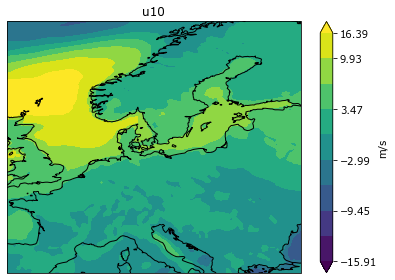

In [39]:
pred_name = "u10"
vmin = colorbar_range[pred_name][0] # Split because string is "tp_tlag0" etc.
vmax = colorbar_range[pred_name][1]
unit = "m/s"
tflag = pred_name

# Plot figure
#---
fig, ax = map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=10)

In [40]:
def predictor_maps(model, X_test, y_test, lons, lats, pred_units, pred_names, station_positions, station_names, is_station_name, is_overlay_importance, run_id, model_run, percentile, markersize, alpha, color, colorbar_range, nlevels=10):
    # TODO: Update predictor_maps in module. This means though that the runs of rf011 will not work anymore, since the function has new input parameters
    """
    Description:
        Plots values of all predictors used for model training. Selects timepoints where Storm Surges were in original data and indicates whether 
        the prediction was true or not in the filename ("isfalse", "istrue"). The file naming "predss" is for situations, where a storm surge was predicted
        but the original data has no storm surge.
    Parameters:
        model (clf): Model that was fitted to X_test, y_test.
        X_test (): Test set of predictor data used for model fit
        y_test (): Test set of predictand data used for model fit
        lons (): Values of longitudes of predictors
        lats (): Values of latitudes of predictors
        pred_units (list): Units of all predictors used, e.g. ms**-1
        pred_names (list): Names of all predictors used, e.g. sp_tlag0
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
        station_name (str): Name of the station given in GESLA dataset.
        is_station_name (bool): Whether to indicate station name in plot or not (Defaults: False)
        is_overlay_importance (bool): Overlay values of importance of that predictor or not
        run_id (int): Number of the model run
        model_run (str): Name of the current model run
        percentile (float): Percentile (0-100) for selecting position of overlayed importance
        markersize (int): Size of square-marked positions of importance
        alpha (float): Transparency of square-markers for importance
        color (str): Color of square-marker for importance
        colorbar_range (dict): Keys are predictors (e.g. "sp"), values are list of [vmin, vmax] values for colorbar
        nlevels (int): Number of levels in contour plot (e.g. sections of the colorbar) (Defaults: 10)

    Returns:
        None
    """
    #---
    # Make a prediction
    #---
    nlat = lats.size
    nlon = lons.size
    y_test_pred = model.predict(X_test) # Predicted data
    importance = model.feature_importances_
    n_pred_features = nlon * nlat # Features per predictor (lon/lat Input-Field). Needed for importance separation

    # Get importance per predictor of model
    #---
    predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

    #---
    # Select data for plotting original storm surge events
    #---
    ss_idx = np.where(y_test == 1) # Timepoints of storm surges in original data

    y_test_ss = y_test[ss_idx] # Original data storm surges only
    y_pred_ss = y_test_pred[ss_idx] # Predictions at timepoints of SS in original data

    ntime = X_test.shape[0]
    X_pred = X_test.reshape(ntime, -1, nlat, nlon) # Reshape to fit format for plotting predictor values on a map

    X_pred_plot = X_pred[ss_idx] # Select only predictor values at timepoints of storm surges

    #---
    # Plot & Save predictor map at original storm surge events
    #---
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    time_idx = 0
    for time in range(n_time):

        is_correct_prediction = (y_test_ss[time] == y_pred_ss[time])

        for pred_idx in range(n_pred):

            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            if is_correct_prediction:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 1"
                fname = f"{pred_names[pred_idx]}_{time_idx}_istrue_{run_id}"
            else:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 0" 
                fname = f"{pred_names[pred_idx]}_{time_idx}_isfalse_{run_id}"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_names[pred_idx].split("_")[0]][0] # Split because string is "tp_tlag0" etc.
            vmax = colorbar_range[pred_names[pred_idx].split("_")[0]][1]

            # Plot figure
            #---
            fig, ax = map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels) # TODO: I need to return axis here, in order to add station and importance
            
            # Add position of station to map
            #---
            for station_name in station_names:
                plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            #---
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)

            # Save plot
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

    #---
    # Plot & Save predictor map of predicted storm surge events where original data has no storm surge 
    #---
    idx2 = np.where(y_test_pred == 1) # Select all occurences where prediction has SS
    y_test_idx2 = y_test[idx2]
    X_pred_plot = X_pred[idx2]
    idx3 = np.where(y_test_idx2 == 0) # Subselect all occurences where prediction has SS and original data has no SS
    X_pred_plot = X_pred_plot[idx3] # Choose this selection as a plot
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    for time in range(n_time):
        for pred_idx in range(n_pred):

            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            tflag = f"{pred_names[pred_idx]},  y_orig = 0, y_pred = 1"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_names[pred_idx].split("_")[0]][0] # Split because string is "tp_tlag0" etc.
            vmax = colorbar_range[pred_names[pred_idx].split("_")[0]][1]
            
            # Plot figure
            #---
            fig, ax = map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels) # TODO: Adjust visualisation.map to return fig,ax?

            # Add position of station to plot
            #---
            for station_name in station_names:
                plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)
            
            # Save figure
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fname = f"{pred_names[pred_idx]}_{time_idx}_predss_{run_id}"

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

        return data, fig, ax # TODO: Delete later: Only do this now to get a figure and axis to work with and overlay importance figure 


In [14]:
# Convert to Series format as it is expected by preprocessing modules
#---
def array_to_series(arr, index, index_name, series_name):
    """
    Description:
        Converts np.array to a pd.Series
    Parameters:
        arr (np.array): Values to convert
        index (list): List of index values corresponding to values in arr
    Returns:
        series (pd.Series): Pandas Series with indicated index names
    """
    station_idx = np.zeros(arr.shape).astype(int)
    d = {f'{index_name}': index, f'{series_name}': arr}
    df = pd.DataFrame(d).set_index(f'{index_name}')
    series = df.squeeze()
    
    return series

Add predictor tp to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Introduce timelags: [0]
Add predictor u10 to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Introduce timelags: [0]
Reshape for model input
(903, 1, 2, 121, 141)
Data is prepared as follows
X.shape : (903, 34122)
y.shape : (903,)
pred_names : ['tp_tlag0', 'u10_tlag0']
pred_units : ['m', 'm s**-1']
Apply train-test-split
File saved to: models/random_forest/rf012/rf012_09519.pkl
Saved Hyperparameters
Fit model with hyperparameters {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 666, 'n_jobs': None, 'oob_score': True, 'random_state': 0, 'verbose': 0,

C:\Users\Kai\AppData\Local\Temp\ipykernel_14096\314947340.py:253: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig1.show()


Show Confusion Matrix on traindata 



C:\Users\Kai\AppData\Local\Temp\ipykernel_14096\314947340.py:257: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig2.show()


saved cf matrix to : results/random_forest/rf012/testcf_matrix_95_0.pdf
saved cf matrix to : results/random_forest/rf012/traincf_matrix_95_0.pdf
Metric values 

tnr: 0.8934010152284264
tpr: 0.5862068965517241
gmean: 0.7236835195810496
wacc: 0.7398039558900753
precision: 0.4473684210526316
recall: 0.5862068965517241
fmeasure: 0.5074626865671642
Metric values 

tnr: 0.9503424657534246
tpr: 0.989247311827957
gmean: 0.9695997780334562
wacc: 0.9697948887906909
precision: 0.7603305785123967
recall: 0.989247311827957
fmeasure: 0.8598130841121494
saved cf metrics to : traincf_metrics_95_0.pkl
Show AUROC 

AUC: 0.8722212497812007


C:\Users\Kai\AppData\Local\Temp\ipykernel_14096\314947340.py:303: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf012/AUROC_95_0.pdf


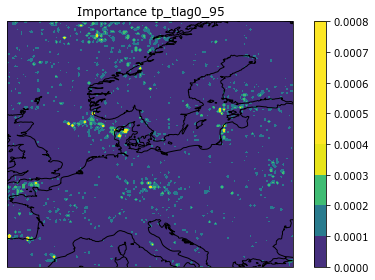

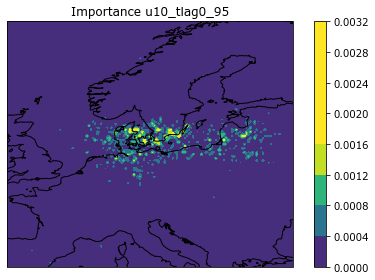

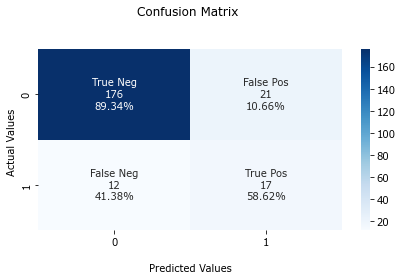

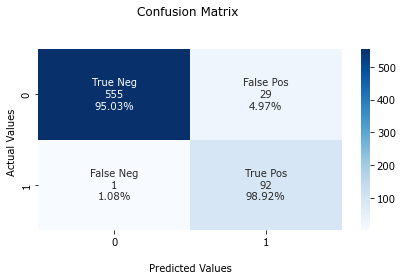

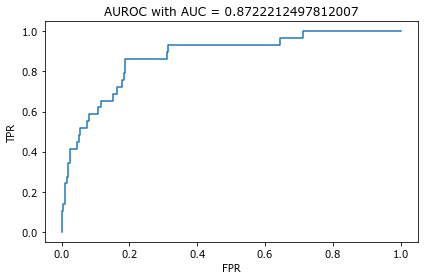

In [15]:
#---
# Load corresponding ERA5-Predictor to get model etc in order to plot figures
#---
import sys
# orig_stdout = sys.stdout
model_run = "rf012"
run_id = 0
colorbar_range = {'sp': np.array([ 69266.47, 100232.51]), # vmin vmax values for colorbar
 'tp': np.array([0.    , 0.0049]),
 'u10': np.array([-18.89,  19.46]),
 'v10': np.array([-20.53,  21.48])}
 
for idx, predictors in enumerate(predictors_of_model): # Loops over separate modelruns 

    # #---
    # # Save printed output to file
    # #---
    folder = f"results/random_forest/{model_run}/"
    saver.directory_existance(folder)
    # file_path = f'{folder}output_runid{run_id}.txt'
    # sys.stdout = open(file_path, "w") 

    #---
    # Load ERA5- Predictor
    #---
    
    # Initialize
    #---
    timelags = timelags_of_model[idx]
    X = []
    Y = []
    t = []
    pred_units = []
    pred_names = []

    # Main
    #---
    for predictor in predictors:
        print(f"Add predictor {predictor} to model input features")

        # Load data of predictor
        #---
        era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
        era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
        X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand)

        print(f"Introduce timelags: {timelags}")
        
        X_timelag, Y_timelag = preprocessing.combine_timelags(X_, Y_, timelags)

        X.append(X_timelag)
        Y.append(Y_timelag)
        t.append(t_)

        # Save unit and name of predictor
        #---
        for timelag_ in timelags:
            pred_units.append(era5_predictor.units)
            pred_names.append(f"{era5_predictor.name}_tlag{timelag_}")

    # Convert to format needed for model fit
    #---      
    X = np.array(X)
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    t = np.array(t)

    # Reshape for model input
    #---
    print(f"Reshape for model input")

    ndim = Y.shape[0]

    X = X.swapaxes(0, 2) # Put time dimension to front

    print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

    X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    X[np.where(np.isnan(X))] = -999

    print("Data is prepared as follows")
    print(f"X.shape : {X.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")

    #---
    # Apply Train-Test split 
    #---
    print("Apply train-test-split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

    # ---
    # Detrend train-test sets separately
    # ---

    # # Convert to expected format 
    # #---
    # test_index = np.zeros(y_test.shape).astype(int) # All zeros because we only selected one station
    # train_index = np.zeros(y_train.shape).astype(int)

    # y_test = array_to_series(y_test, test_index, index_name="station", series_name="sea_level") # DONE: Add do module: Preprocessing
    # y_train = array_to_series(y_train, train_index, index_name="station", series_name="sea_level")

    # # Detrend
    # # ---
    # print("Detrend train-test data for predictand")
    # y_test = gesla_preprocessing.detrend(y_test, level="station")
    # y_train = gesla_preprocessing.detrend(y_train, level="station")

    # # # Apply one hot encoding
    # #---
    # y_test = gesla_preprocessing.apply_dummies(y_test, percentile=percentile, level="station")
    # print(f"Applied one-hot-encoding to test-set with Percentile: {percentile}")

    # y_train = gesla_preprocessing.apply_dummies(y_train, percentile=percentile, level="station")
    # print(f"Applied one-hot-encoding to train-set with Percentile: {percentile}")

    # print(f"{y_train.size} training datapoints used")
    
    # # Convert to DataArray
    # # nan values: no measurement at that timestamp for specific station
    # #---
    # y_test = y_test.to_xarray()
    # y_train = y_train.to_xarray()
    
    #---
    # Scale data if they are on different scales
    #---
    if is_scaled:
        print("Scale training data")
        s = StandardScaler()
        s.fit(X_train)
        X_train = s.transform(X_train)
        X_test = s.transform(X_test)

    #---
    #  Optimize Hyperparameters
    #---
    if is_optimized:
        print(f"Optimize Hyperparameters using {optimizer}")
        print(f"Tested Hyperparameters: {hparam_grid}")
        
        hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)
    
    if is_loaded_hparams:
        model_path = models_path[idx]
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        hparam_grid_opt = model.get_params()
        
    #---
    #  Save hyperparameters
    #---
    folder = f"models/random_forest/{model_run}/" 
    saver.directory_existance(folder)
    saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

    print("Saved Hyperparameters")

    #---
    # Fit the model
    #---
    print(f"Fit model with hyperparameters {hparam_grid_opt}")

    model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

    model.fit(X_train, y_train)

    #---
    # Saving the model
    #---
    print("Save model")
    filename = f'{model_run}_{optimizer}_{run_id}.sav'
    pickle.dump(model, open(f'{folder}{filename}', 'wb'))

    #---
    # Plot Predictor Maps
    #---
    # predictor_maps(model, X_test, y_test, lons, lats, pred_units, pred_names, run_id, model_run,) 
    
    #---
    # Evaluate model / Diagnostic
    #--- 
    print("Evaluate Model \n")

    # Score & Importance
    #---
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
    relative_score = evaluation.relative_scores(train_score, test_score)
    importance = model.feature_importances_

    # Save Scores & Importance
    #---
    folder = f"results/random_forest/{model_run}/"
    saver.directory_existance(folder)

    fname = f"importance_{str(percentile)[-2:]}_{run_id}"
    np.save(f"{folder}{fname}", importance)
    print(f"saved importance to : {folder}{fname}")

    fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
    np.save(f"{folder}{fname}", test_score)
    print(f"saved testscore to : {folder}{fname}")

    fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
    np.save(f"{folder}{fname}", train_score)
    print(f"saved trainscore to : {folder}{fname}")

    fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
    np.save(f"{folder}{fname}", relative_score)
    print(f"saved relativescore to : {folder}{fname}")

    # Plot importance of each predictor from combination
    # Goal:
    # 1. Separate importance per predictor
    # 2. Plot importance of each predictor on lon lat map
    #---
    n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

    predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

    for pred_idx, pred_importance in enumerate(predictor_importances):
        # Plot importance map and save it
        predictor = pred_names[pred_idx] 
        tflag = f"{predictor}_{str(percentile)[-2:]}"

        fig = evaluation.importance_map(pred_importance, lons, lats, tflag)
        
        fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
        fig.savefig(f"{folder}{fname}.pdf")

    #---
    # Confusion matrix
    #---
    # Format: 
    # Reality / Model: Negative, Positive
    # Negative    Right Negative, False Positive 
    # Positive    False Negative, Right Positive

    print("Show Confusion Matrix on testdata \n")
    cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
    cfm_fig1.show()

    print("Show Confusion Matrix on traindata \n")
    cfm_fig2 = evaluation.plot_cf(model, X_train, y_train)
    cfm_fig2.show()

    # Save CFM
    fname = f"{folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
    cfm_fig1.savefig(fname)
    print(f"saved cf matrix to : {fname}")

    fname = f"{folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
    cfm_fig2.savefig(fname)
    print(f"saved cf matrix to : {fname}")

    # Calculate CFM-Metrics
    metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
    metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

    fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
    with open(f"{folder}{fname}", 'wb') as f:
        pickle.dump(metrics1, f)

    fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
    with open(f"{folder}{fname}", 'wb') as f:
        pickle.dump(metrics2, f)

    print(f"saved cf metrics to : {fname}")

    #---
    # AUROC
    # Receiver Operating Characteristics & Area Under the Curve
    #---

    print("Show AUROC \n")

    y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    auc = roc_auc_score(y_test, y_test_proba)

    print(f'AUC: {auc}')

    fig, ax = plt.subplots(tight_layout=True)

    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"AUROC with AUC = {auc}")

    fig.show()

    fname = f"{folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
    fig.savefig(fname)
    print(f"saved AUROC to : {fname}")
    break
    #---
    # Update run_id
    #---
    run_id = run_id + 1
    sys.stdout = orig_stdout # Restore original system output

# Figure for importance

In [16]:
# TODO: Add specific values for vmax for importance map, s.t. it is unified along all?
# Problem: One might not see the regions of importance perfectly
def importance_map(importance, lons, lats, tflag="", ax=None):
    """
    Description:
        Plots importance of a predictor on a lat lon map.
    Parameters:
        importance (np.array): Importances from model classification. Shape:(features,)
        lons (np.array): Longitudes of predictor importance
        lats (np.array): Latitudes of predictor importance
        tflag (str): Additional Title information
    Returns:
        fig: Figure of importance
    """
    # Modules
    import matplotlib.pyplot as plt 
    import cartopy.crs as ccrs

    # Reshape importance to lat/lon
    nlat = len(lats)
    nlon = len(lons)
    importance = importance.reshape(nlat, nlon)

    # Adjust colorbar extremes
    vmax = 0.5 * np.max(importance)

    # Plot importance on lat/lon map
    fig = plt.figure(tight_layout=True,)

    if ax == None:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    plot = ax.contourf(lons, lats, importance, 
    transform=ccrs.PlateCarree(),
    vmax=vmax,
    )

    ax.coastlines()

    plt.colorbar(plot,)

    ax.set_title(f"Importance {tflag}")

    return fig, ax

In [17]:
def overlay_importance(ax, importance, lats, lons, percentile=99, alpha=0.1, markersize=5, color="k"):
    # TODO: put into module
    """
    Description:
        Overlays the position of importance above a specified percentile to an axis.
        Mainly this is used to overlay the importance on predictor maps.
    Parameters:
        ax
        importance
        lats
        lons:
        percentile (float): Percentile between 0. and 100.
    Returns:
    """

    # Reshape importance
    #---
    nlat = len(lats)
    nlon = len(lons)
    importance = importance.reshape(nlat, nlon)

    # Find positions above percentile
    #---
    perc = np.percentile(importance, q=percentile)
    perc_lat_idx, perc_lon_idx = np.where(importance > perc) 
    perc_lats = lats[perc_lat_idx]
    perc_lons = lons[perc_lon_idx]

    # Plot pairs into figure
    #---
    ax.plot(perc_lons, perc_lats, "s", markersize=markersize, alpha=alpha, color=color, transform=ccrs.PlateCarree())

# Overlay importance on predictor data

In [41]:
# Load data of predictor
#---
predictors = ["sp", "tp", "u10", "v10",]
colorbar_range = {}
scaler = 0.80
for predictor in predictors:
    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
    era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
    max_value = np.max(era5_predictor.values)
    min_value = np.min(era5_predictor.values)
    print(f"Predictor: {predictor}, unit: {era5_predictor.units}")
    print(f"max:{max_value}, min: {min_value}")

    decimals = 2
    if predictor == "tp":
        decimals = 4
    colorbar_range[predictor] = np.round([scaler * min_value, scaler * max_value ], decimals)

timeseries is already of dtype datetime64[ns]
Predictor: sp, unit: Pa
max:105507.90625, min: 72912.0703125
timeseries is already of dtype datetime64[ns]
Predictor: tp, unit: m
max:0.005182523280382156, min: 0.0
timeseries is already of dtype datetime64[ns]
Predictor: u10, unit: m s**-1
max:20.48837661743164, min: -19.883968353271484
timeseries is already of dtype datetime64[ns]
Predictor: v10, unit: m s**-1
max:22.60782241821289, min: -21.605268478393555


In [27]:
# colorbar_range = {'sp': np.array([ 69266.47, 100232.51]), # vmin vmax values for colorbar
#  'tp': np.array([0.    , 0.0049]),
#  'u10': np.array([-18.89,  19.46]),
#  'v10': np.array([-20.53,  21.48])}
colorbar_range

{'sp': array([58329.66, 84406.33]),
 'tp': array([0.    , 0.0041]),
 'u10': array([-15.91,  16.39]),
 'v10': array([-17.28,  18.09])}

C:\Users\Kai\AppData\Local\Temp\ipykernel_14096\2738015569.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(tight_layout=True,)


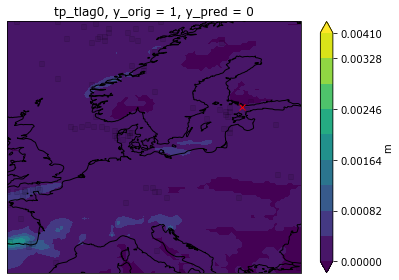

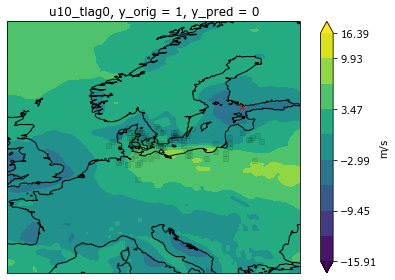

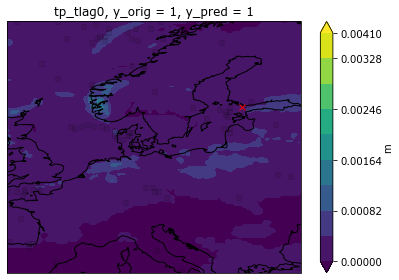

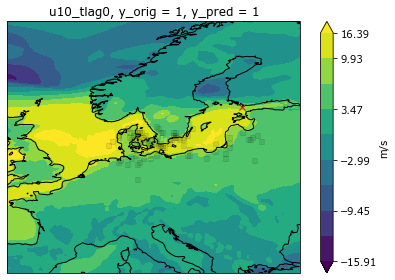

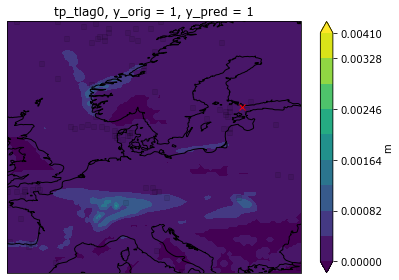

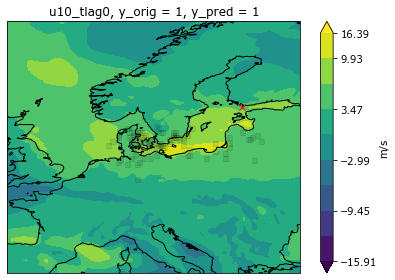

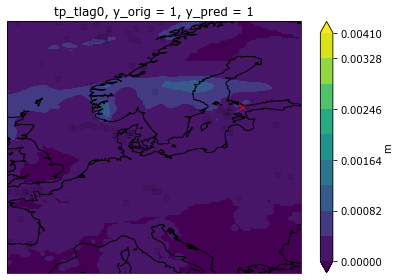

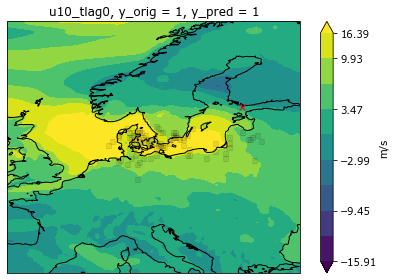

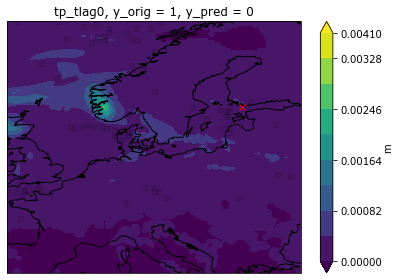

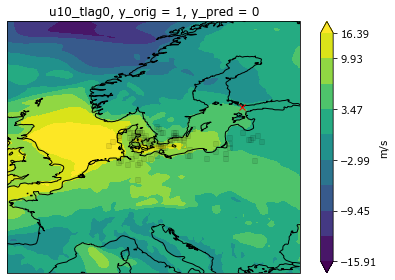

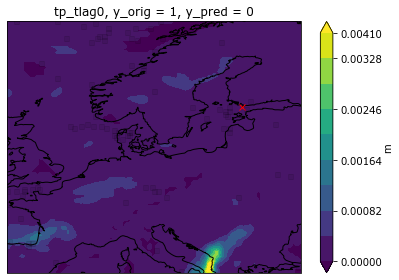

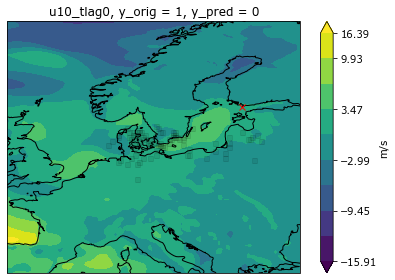

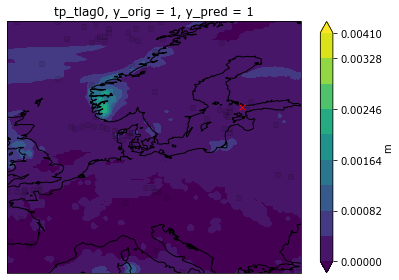

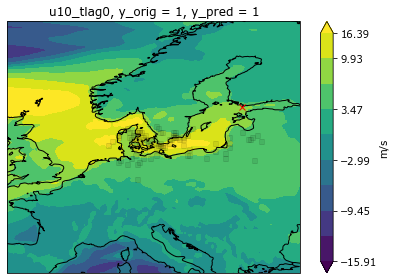

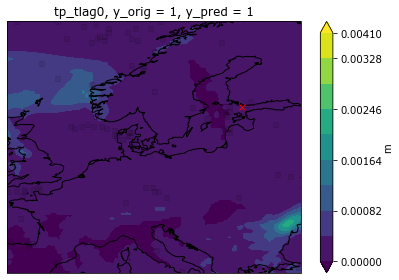

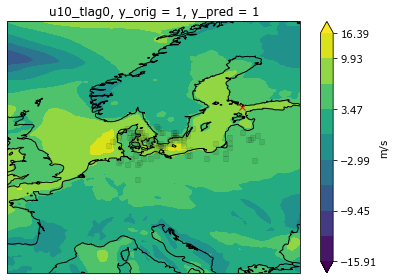

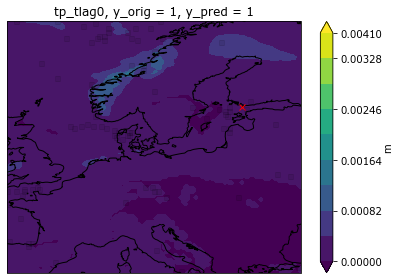

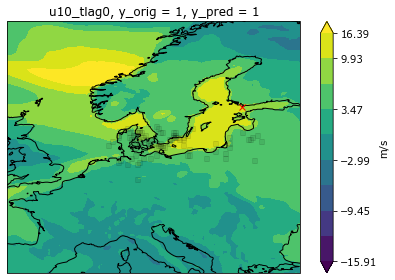

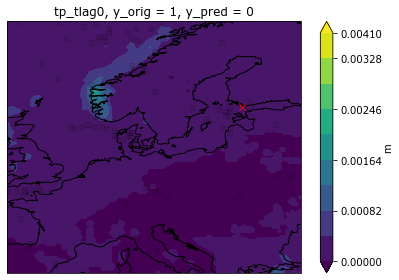

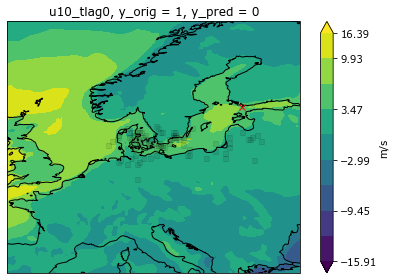

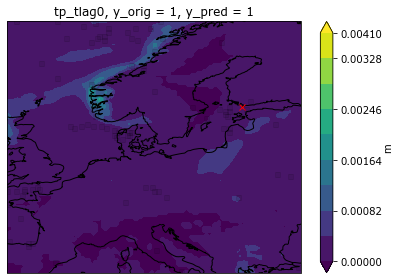

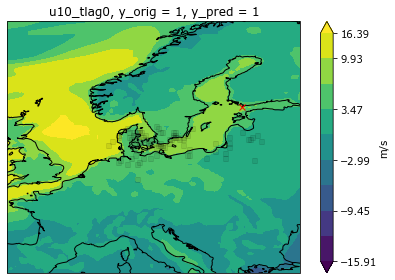

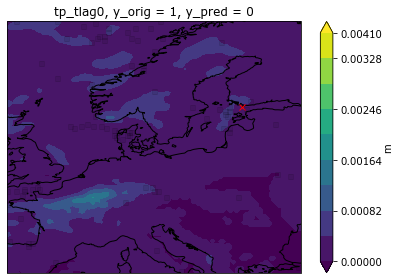

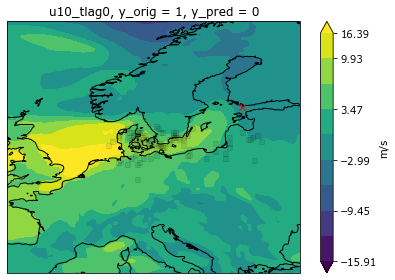

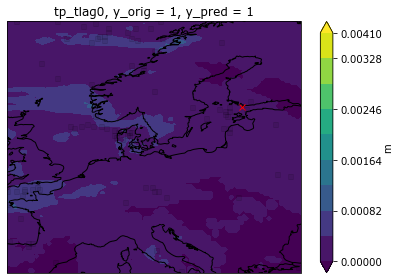

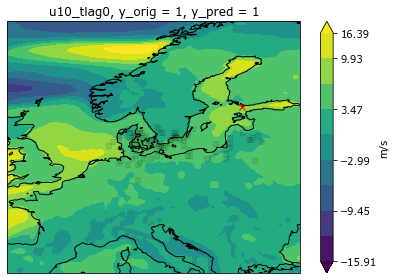

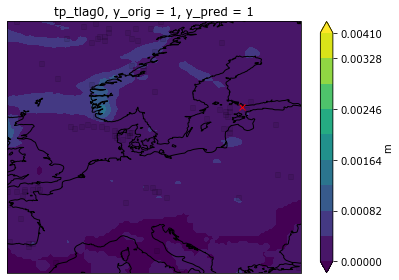

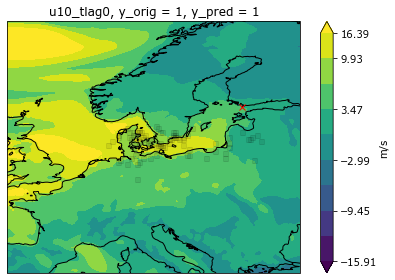

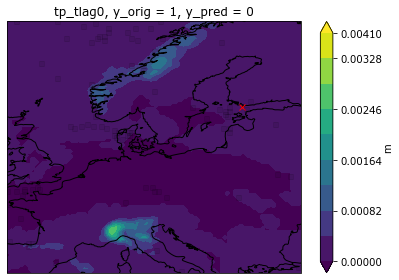

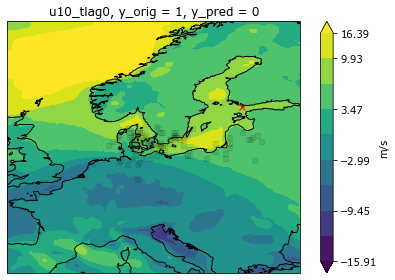

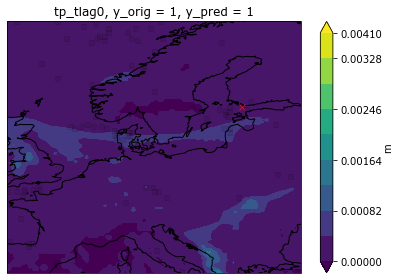

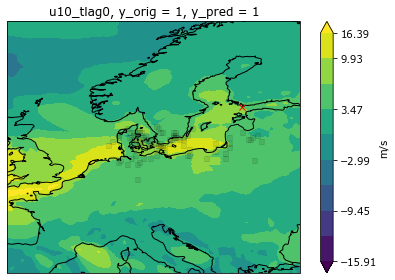

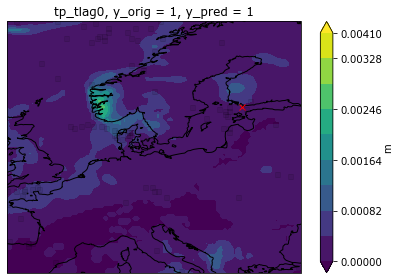

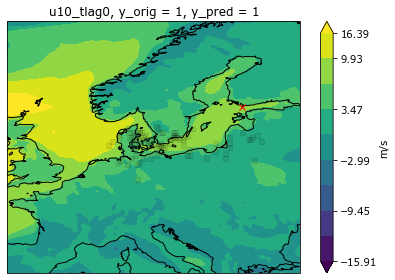

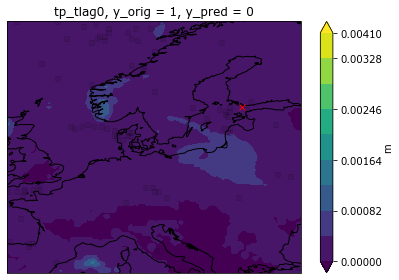

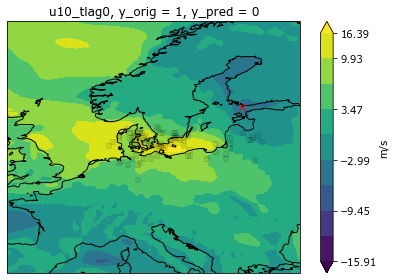

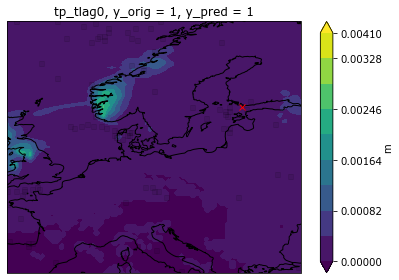

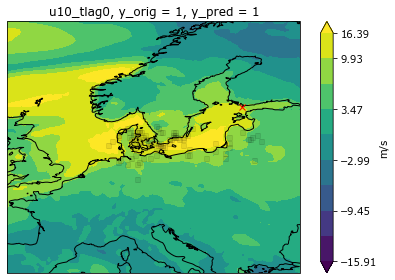

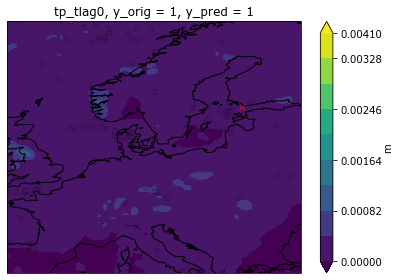

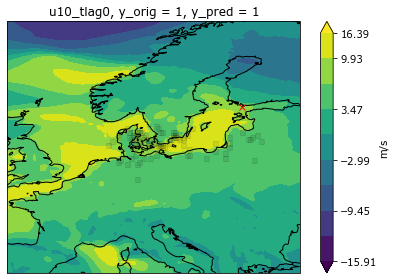

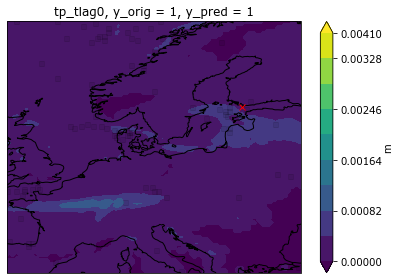

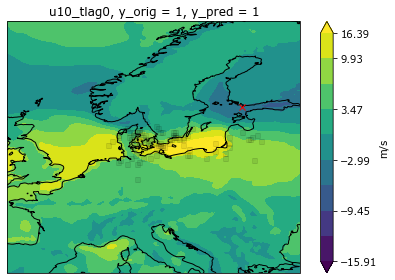

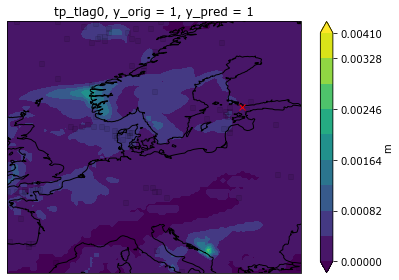

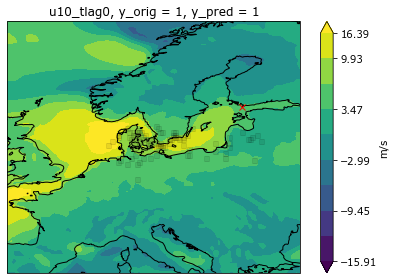

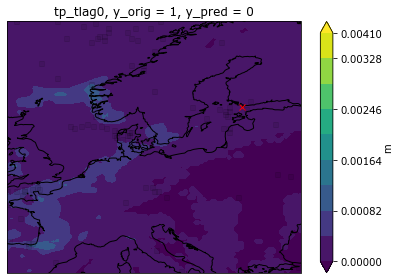

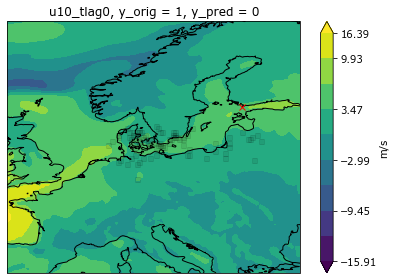

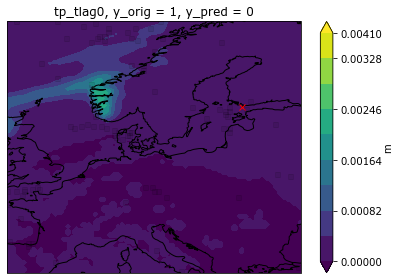

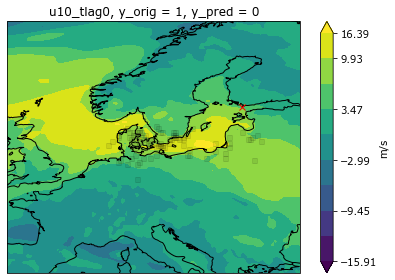

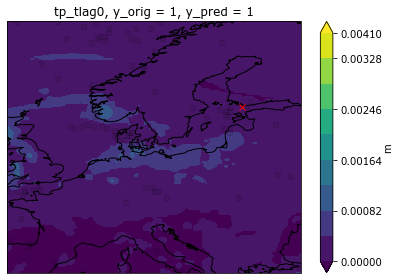

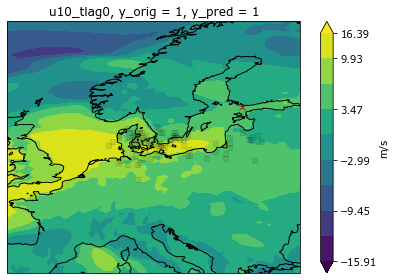

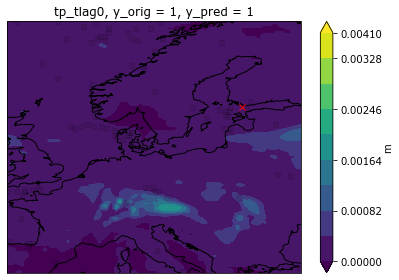

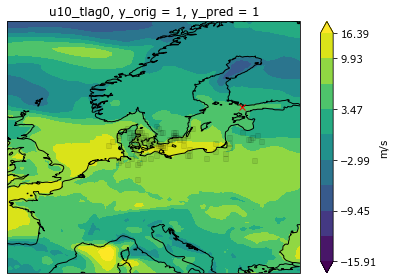

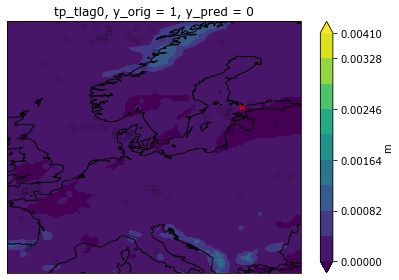

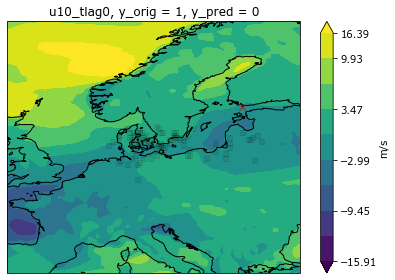

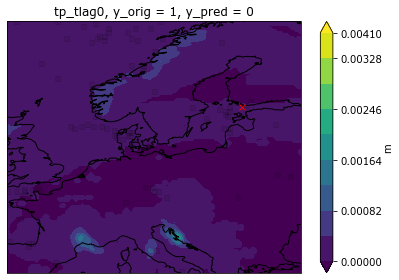

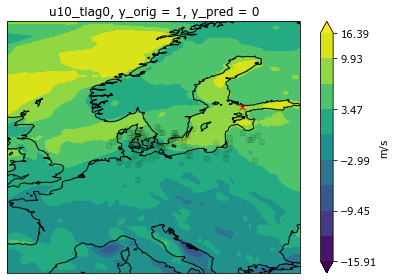

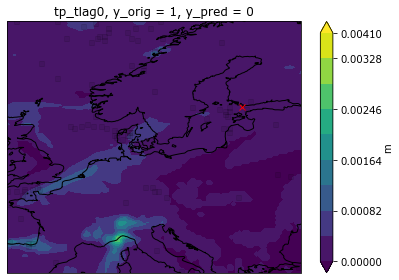

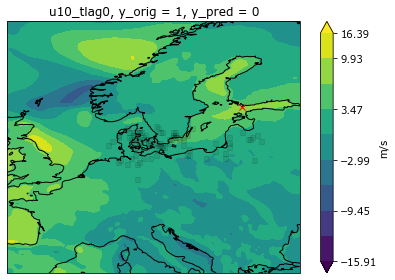

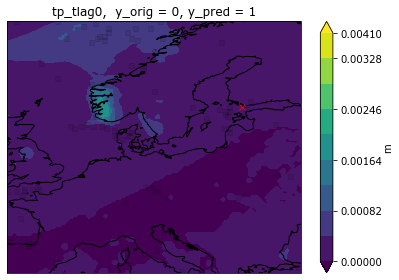

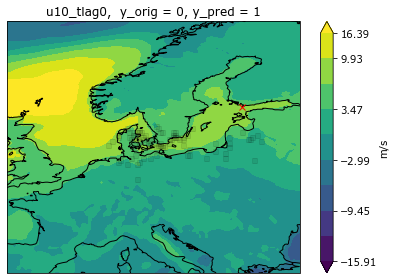

In [42]:
# Check against importances returned by predictor_maps
#---
is_station_name = False
is_overlay_importance = True
nlevels=10
data, fig, ax = predictor_maps(
    model, X_test, y_test, 
    lons, lats, pred_units, pred_names, 
    station_positions, station_names, is_station_name, 
    is_overlay_importance, 
    run_id, model_run, 
    percentile=99.5, markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,)

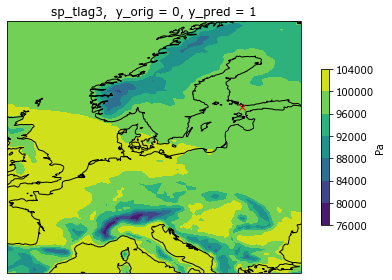

In [ ]:
fig

In [ ]:
importance = model.feature_importances_
n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

for pred_idx, pred_importance in enumerate(predictor_importances):
    overlay_importance(ax, pred_importance, lats, lons, percentile=99, alpha=0.06, markersize=4, color="k")

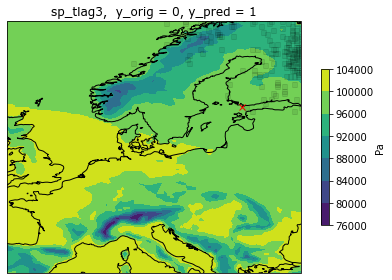

In [ ]:
fig

# Load predictor data to check vmax vmin

In [47]:
# Load data of predictor
#---
predictors = ["sp", "tp", "u10", "v10",]
pred_vmin_vmax = {}
scaler = 0.95
for predictor in predictors:
    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
    era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
    max_value = np.max(era5_predictor.values)
    min_value = np.min(era5_predictor.values)
    print(f"Predictor: {predictor}, unit: {era5_predictor.units}")
    print(f"max:{max_value}, min: {min_value}")

    decimals = 2
    if predictor == "tp":
        decimals = 4
    pred_vmin_vmax[predictor] = np.round([scaler * min_value, scaler * max_value ], decimals)

timeseries is already of dtype datetime64[ns]
Predictor: sp, unit: Pa
max:105507.90625, min: 72912.0703125
timeseries is already of dtype datetime64[ns]
Predictor: tp, unit: m
max:0.005182523280382156, min: 0.0
timeseries is already of dtype datetime64[ns]
Predictor: u10, unit: m s**-1
max:20.48837661743164, min: -19.883968353271484
timeseries is already of dtype datetime64[ns]
Predictor: v10, unit: m s**-1
max:22.60782241821289, min: -21.605268478393555


In [48]:
pred_vmin_vmax

{'sp': array([ 69266.47, 100232.51]),
 'tp': array([0.    , 0.0049]),
 'u10': array([-18.89,  19.46]),
 'v10': array([-20.53,  21.48])}